In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from subprocess import call
from scipy.stats.distributions import gamma,lognorm
import json 
import wget
import os
import os.path

if os.path.exists(os.getcwd()+"\\national.json"):
    os.remove(os.getcwd()+"\\national.json")
wget.download('https://api.covid19india.org/data.json', os.getcwd()+"\\national.json")

if os.path.exists(os.getcwd()+"\\states.json"):
    os.remove(os.getcwd()+"\\states.json")
wget.download('https://api.covid19india.org/states_daily.json', os.getcwd()+"\\states.json")

if os.path.exists(os.getcwd()+"\\test.json"):
    os.remove(os.getcwd()+"\\test.json")
wget.download('https://api.covid19india.org/state_test_data.json', os.getcwd()+"\\test.json")

100% [............................................................................] 893223 / 893223

'E:\\Coronavirus\\Rt comm\\test.json'

In [38]:
dates = np.array([pd.to_datetime(i['date']+"2020") for i in json.load(open('national.json',))['cases_time_series']])
confirmed = np.array([int(i['dailyconfirmed'])for i in json.load(open('national.json',))['cases_time_series']])
deceased = np.array([int(i['dailydeceased'])for i in json.load(open('national.json',))['cases_time_series']])
recovered = np.array([int(i['dailyrecovered'])for i in json.load(open('national.json',))['cases_time_series']])

confirmed = confirmed[dates>=pd.to_datetime("03/04/20")]
deceased = deceased[dates>=pd.to_datetime("03/04/20")]
recovered = recovered[dates>=pd.to_datetime("03/04/20")]
dates = dates[dates>=pd.to_datetime("03/04/20")]

In [39]:
dece = []
reco = []
conf = []

for n in range(100):
    print("Iteration: ",n+1,end='\r')
    dataset = np.copy(deceased)
    mean = 13.0+(20.9-8.7)/4*np.random.normal()
    sd = 12.7+(26.0-6.4)/4*np.random.normal()
    phi = np.sqrt(sd**2 + mean**2)
    mu = np.log(mean**2/phi)
    sigma = np.sqrt(np.log(phi**2/mean**2))
    L = lognorm(s=sigma,scale=np.exp(mu))
    for i in range(len(dataset)):
        send_back = np.round(L.rvs(dataset[i]))
        send_back = send_back[i-send_back>=0]
        dataset[i] = 0
        for j in np.unique(np.int32(send_back)):
            dataset[i-j] += np.sum(send_back==j)
    dataset[::-1] = dataset[::-1]+np.random.negative_binomial(n=dataset[::-1]+1,p=L.cdf(np.arange(len(dataset))),size=len(dataset)) 
    dece.append(dataset)
    dataset = np.copy(recovered)
    mean = 13.0+(20.9-8.7)/4*np.random.normal()
    sd = 12.7+(26.0-6.4)/4*np.random.normal()
    phi = np.sqrt(sd**2 + mean**2)
    mu = np.log(mean**2/phi)
    sigma = np.sqrt(np.log(phi**2/mean**2))
    L = lognorm(s=sigma,scale=np.exp(mu))
    for i in range(len(dataset)):
        send_back = np.round(L.rvs(dataset[i]))
        send_back = send_back[i-send_back>=0]
        dataset[i] = 0
        for j in np.unique(np.int32(send_back)):
            dataset[i-j] += np.sum(send_back==j)
    dataset[::-1] = dataset[::-1]+np.random.negative_binomial(n=dataset[::-1]+1,p=L.cdf(np.arange(len(dataset))),size=len(dataset)) 
    reco.append(dataset)

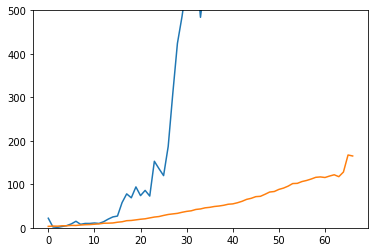

In [43]:
plt.ylim(0,500)
plt.plot(confirmed[:-10])
plt.plot(np.nanmean(dece, axis=0)[:-10])

In [70]:
CFR = np.array(dece)/(np.array(dece)+np.array(reco))#confirmed
# CFR = np.cumsum(dece,axis=1)/(np.cumsum(dece,axis=1)+np.cumsum(reco,axis=1))
col_mean = np.nanmean(CFR, axis=0)
inds = np.where(np.isnan(CFR))
CFR[inds] = np.take(col_mean, inds[1])

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [71]:
leave = np.argmin(np.std(CFR,axis=0)[~np.isnan(np.std(CFR,axis=0))])


D:\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


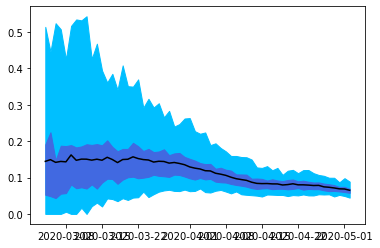

In [72]:
plt.plot(pd.Series(dates)[:leave],np.mean(CFR,axis=0)[:leave],color='k')
#plt.plot(pd.Series(dates)[:leave],np.cumsum(deceased)[:leave]/(np.cumsum(deceased[:leave])+np.cumsum(recovered[:leave])),color='r')

plt.fill_between(pd.Series(dates)[:leave],np.quantile(CFR,0.025,axis=0)[:leave],np.quantile(CFR,0.975,axis=0)[:leave],color='deepskyblue')
plt.fill_between(pd.Series(dates)[:leave],np.quantile(CFR,0.25,axis=0)[:leave],np.quantile(CFR,0.75,axis=0)[:leave],color='royalblue')

In [46]:
json_data = {}

leave = np.argmin(np.std(CFR,axis=0)[:-1])
india = {
        'dates':list(pd.Series(dates)[:leave].dt.strftime('%m-%d-%Y')),
        'cfr_point':list(np.mean(CFR,axis=0)[:leave]),
        'cfr_sd':list(np.std(CFR,axis=0)[:leave]),
        'cfr_l95':list(np.quantile(CFR,0.025,axis=0)[:leave]),
        'cfr_u95':list(np.quantile(CFR,0.975,axis=0)[:leave]),
        'cfr_l50':list(np.quantile(CFR,0.25,axis=0)[:leave]),
        'cfr_u50':list(np.quantile(CFR,0.75,axis=0)[:leave]),
        }

json_data['IN'] = india

### State Level Data

In [74]:
states = list(filter(lambda v:len(v)<3,list(json.load(open('states.json',))['states_daily'][0].keys())))

In [75]:
dates = np.array([pd.to_datetime(i['date']) for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
data_recovered = pd.DataFrame()
data_deceased = pd.DataFrame()
data_confirmed = pd.DataFrame()
for st in states:
    data_confirmed[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Confirmed',json.load(open('states.json',))['states_daily'])])
    data_deceased[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Deceased',json.load(open('states.json',))['states_daily'])])
    data_recovered[st] = np.array([i[st] for i in filter(lambda v: v['status'] == 'Recovered',json.load(open('states.json',))['states_daily'])])

In [76]:
data_recovered = data_recovered.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_recovered = data_recovered.astype(np.int32)
data_confirmed = data_confirmed.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_confirmed = data_confirmed.astype(np.int32)
data_deceased = data_deceased.replace(r'^\s*$', np.NaN, regex=True).fillna(0)
data_deceased = data_deceased.astype(np.int32)
data_deceased['date'] = dates
data_recovered['date'] = dates
data_confirmed['date'] = dates


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


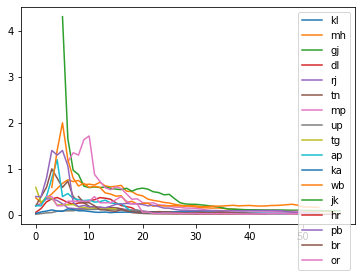

In [79]:
state_id = {"kl":"Kerala",
"mh":"Maharashtra",
"gj":"Gujarat",
"dl":"Delhi",
"rj":"Rajasthan",
"tn":"Tamil Nadu",
"mp":"Madhya Pradesh",
"up":"Uttar Pradesh",
"tg":"Telangana",
"ap":"Andhra Pradesh",
"ka":"Karnataka",
"wb":"West Bengal",
"jk":"Jammu and Kashmir",
"hr":"Haryana",
"pb":"Punjab",
"br":"Bihar",
"or":"Odisha" }

for state in state_id.keys():
    boots = 5
    dece = []
    reco = []
    for n in range(boots):
        print("Iteration: ",n+1,end='\r')
        dataset = np.copy(data_deceased[state].values)
        mean = 13.0+(20.9-8.7)/4*np.random.normal()
        sd = 12.7+(26.0-6.4)/4*np.random.normal()
        phi = np.sqrt(sd**2 + mean**2)
        mu = np.log(mean**2/phi)
        sigma = np.sqrt(np.log(phi**2/mean**2))
        L = lognorm(s=sigma,scale=np.exp(mu))
        for i in range(len(dataset)):
            send_back = np.round(L.rvs(np.max([0,int(dataset[i])])))
            send_back = send_back[i-send_back>=0]
            dataset[i] = 0
            for j in np.unique(np.int32(send_back)):
                dataset[i-j] += np.sum(send_back==j)
        dataset[::-1] = dataset[::-1]+np.random.negative_binomial(n=dataset[::-1]+1,p=L.cdf(np.arange(len(dataset))),size=len(dataset)) 
        dece.append(dataset)
        dataset = np.copy(data_recovered[state].values)
        mean = 13.0+(20.9-8.7)/4*np.random.normal()
        sd = 12.7+(26.0-6.4)/4*np.random.normal()
        phi = np.sqrt(sd**2 + mean**2)
        mu = np.log(mean**2/phi)
        sigma = np.sqrt(np.log(phi**2/mean**2))
        L = lognorm(s=sigma,scale=np.exp(mu))
        for i in range(len(dataset)):
            send_back = np.round(L.rvs(np.max([0,int(dataset[i])])))
            send_back = send_back[i-send_back>=0]
            dataset[i] = 0
            for j in np.unique(np.int32(send_back)):
                dataset[i-j] += np.sum(send_back==j)
        dataset[::-1] = dataset[::-1]+np.random.negative_binomial(n=dataset[::-1]+1,p=L.cdf(np.arange(len(dataset))),size=len(dataset)) 
        reco.append(dataset)
#     CFR = np.array(dece)/data_confirmed[state].values#(np.array(dece)+np.array(reco))
    CFR = np.cumsum(dece,axis=1)/np.cumsum(data_confirmed[state].values)#(np.cumsum(dece,axis=1)+np.cumsum(reco,axis=1))
    col_mean = np.nanmean(CFR, axis=0)
    inds = np.where(np.isnan(CFR))
    CFR[inds] = np.take(col_mean, inds[1])
    leave = np.argmin(np.std(CFR,axis=0)[~np.isnan(np.std(CFR,axis=0))])
    temp = {
    'dates':list(pd.Series(dates)[:leave].dt.strftime('%m-%d-%Y')),
    'cfr_point':list(np.mean(CFR,axis=0)[:leave]),
    'cfr_sd':list(np.std(CFR,axis=0)[:leave]),
    'cfr_l95':list(np.quantile(CFR,0.025,axis=0)[:leave]),
    'cfr_u95':list(np.quantile(CFR,0.975,axis=0)[:leave]),
    'cfr_l50':list(np.quantile(CFR,0.25,axis=0)[:leave]),
    'cfr_u50':list(np.quantile(CFR,0.75,axis=0)[:leave]),
    }
    json_data[state] = temp
    plt.plot(temp['cfr_point'],label=state)
plt.legend()

In [80]:
with open('cfr.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [81]:
states = np.unique([x['state'] for x in json.load(open('test.json',))['states_tested_data']])

In [82]:
testing = {}

for st in states:
    dates = [x['updatedon'] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])]    
    rates = [x['testpositivityrate'][:-1] for x in filter(lambda v: v['state'] == st,json.load(open('test.json',))['states_tested_data'])]
    testing[st] = {
                    'dates':dates,
                    'positivity':rates
                  }

In [83]:
testing

{'Andaman and Nicobar Islands': {'dates': ['17/04/2020',
   '24/04/2020',
   '27/04/2020',
   '01/05/2020',
   '16/05/2020'],
  'positivity': ['0.86', '1.01', '1.16', '0.88', '0.49']},
 'Andhra Pradesh': {'dates': ['02/04/2020',
   '10/04/2020',
   '11/04/2020',
   '12/04/2020',
   '13/04/2020',
   '14/04/2020',
   '15/04/2020',
   '16/04/2020',
   '17/04/2020',
   '18/04/2020',
   '19/04/2020',
   '20/04/2020',
   '21/04/2020',
   '22/04/2020',
   '23/04/2020',
   '24/04/2020',
   '25/04/2020',
   '26/04/2020',
   '27/04/2020',
   '28/04/2020',
   '29/04/2020',
   '30/04/2020',
   '01/05/2020',
   '02/05/2020',
   '03/05/2020',
   '04/05/2020',
   '05/05/2020',
   '06/05/2020',
   '07/05/2020',
   '08/05/2020',
   '09/05/2020',
   '10/05/2020',
   '11/05/2020',
   '12/05/2020',
   '13/05/2020',
   '14/05/2020',
   '15/05/2020',
   '17/05/2020',
   '18/05/2020',
   '19/05/2020'],
  'positivity': ['7.33',
   '5.73',
   '5.48',
   '5.82',
   '4.93',
   '4.50',
   '4.52',
   '2.64',
   '2

In [84]:
json.load(open('national.json',))['tested']

[{'individualstestedperconfirmedcase': '75.64',
  'positivecasesfromsamplesreported': '',
  'samplereportedtoday': '',
  'source': 'Press_Release_ICMR_13March2020.pdf',
  'sourceindiapopulationncpprojection2019httpsnhm.gov.innewupdates2018reportpopulationprojection2019.pdf': '1332900000',
  'testpositivityrate': '1.20%',
  'testsconductedbyprivatelabs': '',
  'testsperconfirmedcase': '83.33',
  'testspermillion': '5',
  'totalindividualstested': '5900',
  'totalpositivecases': '78',
  'totalsamplestested': '6500',
  'updatetimestamp': '13/03/2020 00:00:00'},
 {'individualstestedperconfirmedcase': '81.57',
  'positivecasesfromsamplesreported': '',
  'samplereportedtoday': '',
  'source': 'ICMR_website_update_18March_6PM_IST.pdf',
  'sourceindiapopulationncpprojection2019httpsnhm.gov.innewupdates2018reportpopulationprojection2019.pdf': '',
  'testpositivityrate': '1.14%',
  'testsconductedbyprivatelabs': '',
  'testsperconfirmedcase': '87.50',
  'testspermillion': '10',
  'totalindividua

In [85]:
dates = [x['updatetimestamp'] for x in json.load(open('national.json',))['tested']]    
rates = [x['testpositivityrate'][:-1] for x in json.load(open('national.json',))['tested']]
testing['IN'] = {
                'dates':dates,
                'positivity':rates
              }

In [86]:
with open('testing.json', 'w') as outfile:
    json.dump(testing, outfile)